In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import imageio
from PIL import Image, ImageOps
import scipy.ndimage as ndi
import seaborn as sns
import cv2
import os
import random
import shutil
import glob
import urllib.request
import tensorflow as tf 
from tensorflow.python.framework import ops
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

In [124]:
# Pneumonia images upload
total_images_train_normal = os.listdir('C:/study/Artem/data-scince_A/open program/datasets/chest_xray/chest_xray/train/NORMAL/')
total_images_train_pneumonia = os.listdir('C:/study/Artem/data-scince_A/open program/datasets/chest_xray/chest_xray/train/PNEUMONIA/')
# swaps val and test data because of the number of files

train_dir = 'C:/study/Artem/data-scince_A/open program/datasets/chest_xray/train'
train_nrml_pth = os.path.join(train_dir, 'NORMAL')
train_pnm_pth = os.path.join(train_dir, 'PNEUMONIA')
val_dir = 'C:/study/Artem/data-scince_A/open program/datatsets/chest_xray/test'
test_nrml_pth = os.path.join(val_dir, 'NORMAL')
test_pnm_pth = os.path.join(val_dir, 'PNEUMONIA')
test_dir = 'C:/study/Artem/data-scince_A/open program/datasets/chest_xray/test'
val_nrml_pth = os.path.join(test_dir, 'NORMAL')
val_pnm_pth = os.path.join(test_dir, 'PNEUMONIA')

In [142]:
# Bone age images upload

base_bone_dir = 'C:/study/Artem/data-scince_A/open program/datasets/bone_age'
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
6950,9277,168,True,C:/study/Artem/data-scince_A/open program/data...,True,male,168.0
8571,11089,162,True,C:/study/Artem/data-scince_A/open program/data...,True,male,162.0
8954,11530,120,False,C:/study/Artem/data-scince_A/open program/data...,True,female,120.0


In [110]:
def files_per_directory(base_dir, categories):
    files_per_dir = []

    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        files_per_dir.append(len(files))

    return files_per_dir
train_files = files_per_directory(train_dir, train_categories)
val_files = files_per_directory(val_dir, val_categories)
test_files = files_per_directory(test_dir, test_categories)

In [111]:
train_categories = [x for x in os.listdir(train_dir) if x[0] is not '.']
val_categories = [x for x in os.listdir(val_dir) if x[0] is not '.']
test_categories = [x for x in os.listdir(test_dir) if x[0] is not '.']

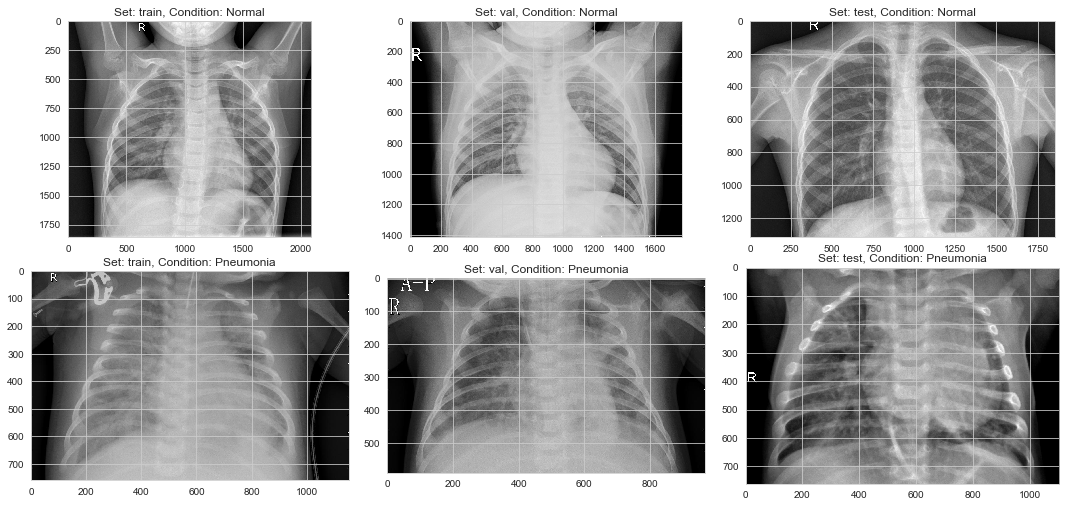

In [112]:
input_path = 'C:/study/Artem/data-scince_A/open program/datasets/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [138]:
#Method to get photos out of the folder 
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.imshow(img)

    plt.tight_layout()


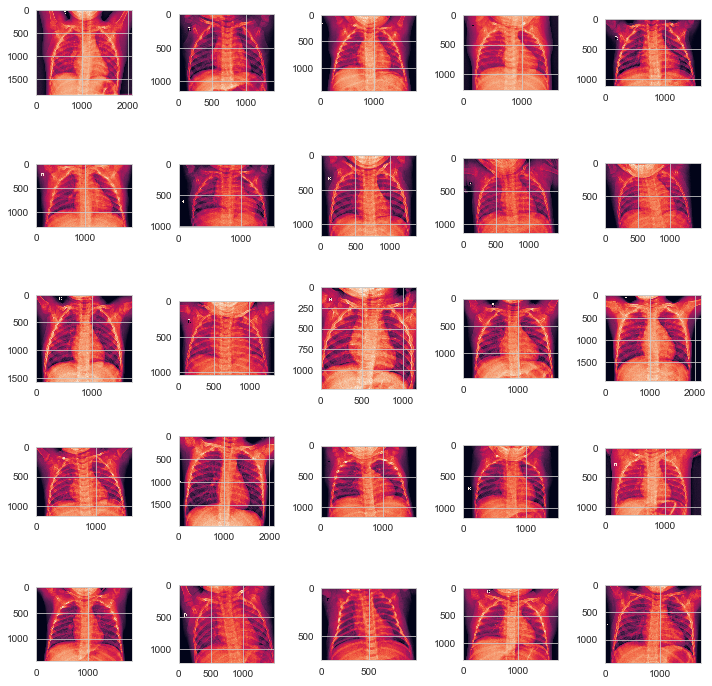

In [140]:
#Some photos of healthy people.
plot_imgs(train_nrml_pth)

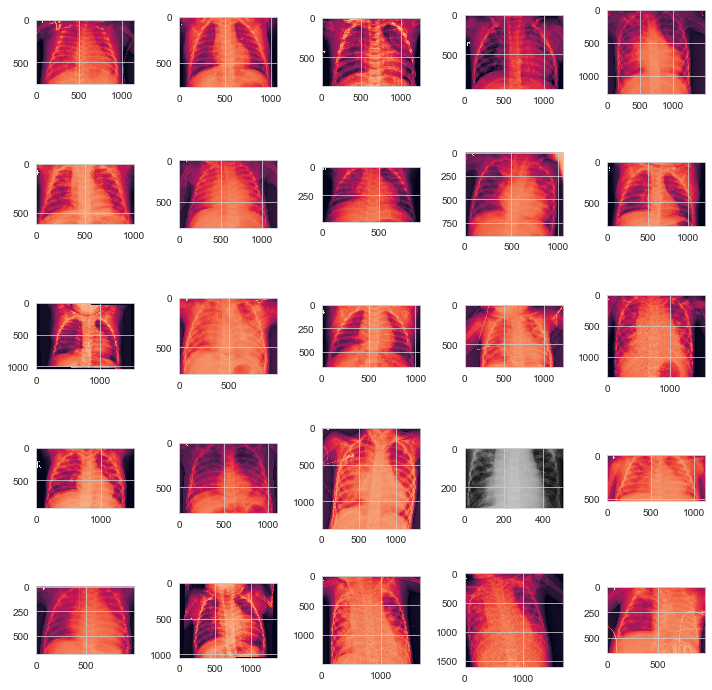

In [126]:
# photos of sick patients.
plot_imgs(train_pnm_pth)

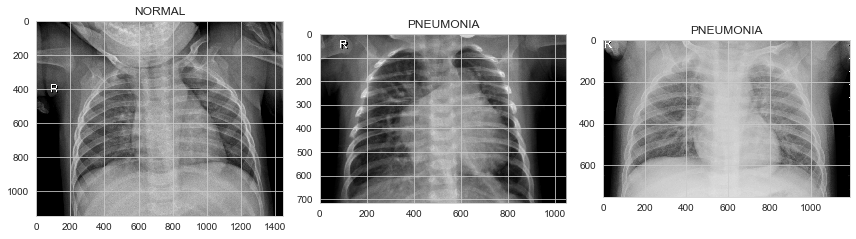

In [113]:

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

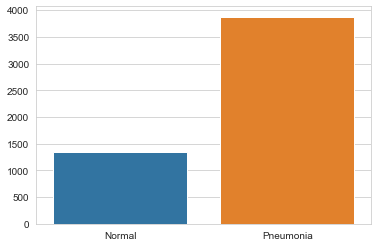

In [114]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

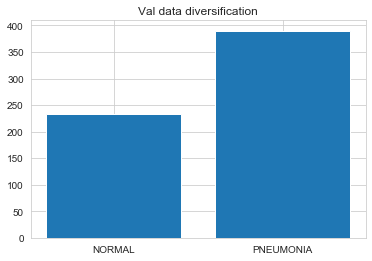

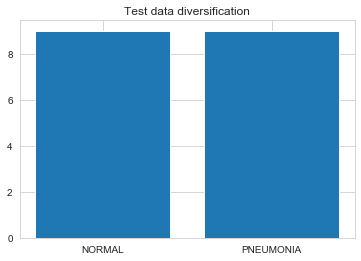

In [116]:
def plot_diversification(files_per_dir, categories, title='diversification'):
    plt.bar([x for x in range(len(files_per_dir))],
            files_per_dir, tick_label=categories)
    plt.title(title)
    plt.show()
plot_diversification(val_files, 
                     val_categories, 
                     title='Val data diversification')
plot_diversification(test_files, 
                     test_categories, 
                     title='Test data diversification')

In [130]:
#Histograms using matplotlib and resizing 
def plot_img_hist(item_dir, num_img=6):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_img]
  
  #plt.figure(figsize=(10, 10))
  for idx, img_path in enumerate(item_files):
    fig1 = plt.figure(idx,figsize=(10, 10))
    fig1.add_subplot(2, 2, 1)
    img = mpimg.imread(img_path, )
    plt.imshow(img)
    fig1.add_subplot(2, 2, 2)
    plt.hist(img.ravel(),bins=256, fc='k', ec='k')
  
  plt.tight_layout()

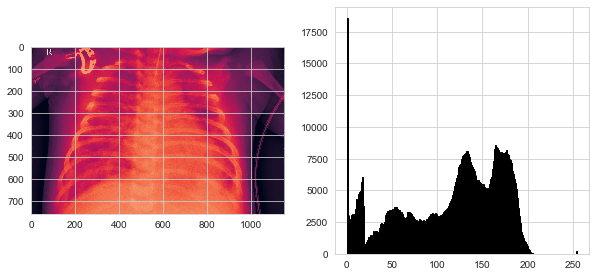

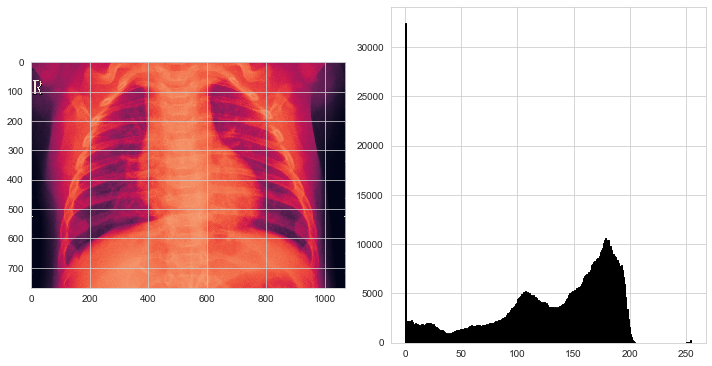

In [131]:
plot_img_hist(train_pnm_pth,2)

In [132]:
#Then I found that I can also do it with scipy and I found out how to calculate Cumulative Distribution Function. 
#I found out about scipy.ndimage on Data Camp Image Processing course.

def plot_img_hist_ndi(item_dir, num_img=6):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_img]
  
  #plt.figure(figsize=(10, 10))
  for idx, img_path in enumerate(item_files):
    im = imageio.imread(img_path)
    hist = ndi.histogram(im, min=0, max=255, bins=256)
    cdf = hist.cumsum() / hist.sum()
    
    fig1 = plt.figure(idx,figsize=(10, 10))
    fig1.add_subplot(2, 3, 1)
    img = mpimg.imread(img_path, )
    plt.title("No. {}".format(idx))
    plt.imshow(img)
    fig1.add_subplot(2, 3, 2)
    plt.title("Histogram")
    plt.plot(hist)
    fig1.add_subplot(2, 3, 3)
    plt.title("CDF")
    plt.plot(cdf)

  plt.tight_layout()

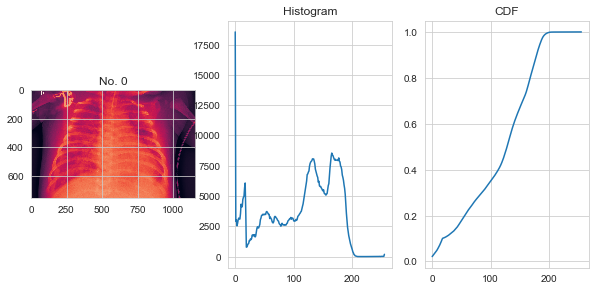

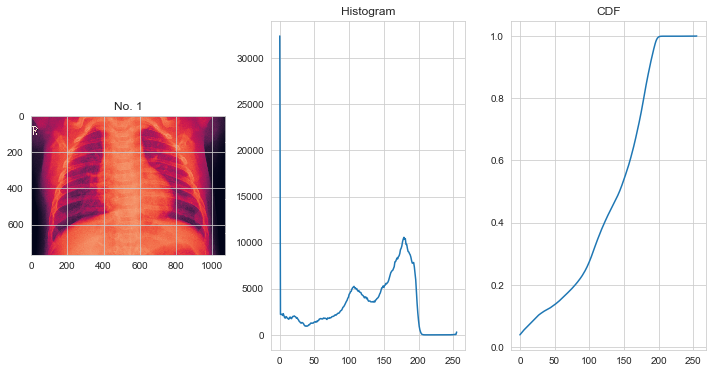

In [137]:
plot_img_hist_ndi(train_pnm_pth,2)